<a href="https://colab.research.google.com/github/PiatekBartosz/SyntheticDatasetForYoloV5/blob/main/YoloV5SyntheticDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use pip insatll albumentations and opencv to fix "module 'albumentations' has no attribute 'Sequential'" error

In [1]:
!pip install -U albumentations
!pip install --upgrade opencv-python
import cv2 as cv
print(cv.__version__)#4.5.5
import albumentations as A
print(A.__version__)#1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
4.6.0
1.2.1


Import section

In [2]:
# import albumentations as A
# import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
import time
from tqdm import tqdm

Connect to google drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load images and masks


---


Desired folder structure:

drive
* MyDrive
  * Machine learning dataset
    * 3-bit
      * images
      * masks
    * bg
    * bg_noise
      * images
      * masks


In [14]:
obj_dict = {
    # images longest sides bounderies in px
    1: {"folder": "3-bit", 'longest_min': 150, 'longest_max': 800}, 
    2: {"folder": "mars", 'longest_min': 150, 'longest_max': 800},
    3: {"folder": "mway", 'longest_min': 150, 'longest_max': 800},
    4: {"folder": "snk", 'longest_min': 150, 'longest_max': 800}
}

PATH_MAIN = "drive/MyDrive/Machine learning dataset"

for k, _ in obj_dict.items():
  folder_name = obj_dict[k]['folder']

  files_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, folder_name, 'images')))
  files_imgs = [os.path.join(PATH_MAIN, folder_name, 'images', f) for f in files_imgs]

  files_masks = sorted(os.listdir(os.path.join(PATH_MAIN, folder_name, 'masks')))
  files_masks = [os.path.join(PATH_MAIN, folder_name, 'masks', f) for f in files_masks]

  obj_dict[k]['images'] = files_imgs
  obj_dict[k]['masks'] = files_masks

for i in obj_dict:
    print(f"Import no. {i}: ", len(obj_dict[i]['images']), "images")
    print(f"Import no. {i}: ", len(obj_dict[i]['masks']), "masks")

Import no. 1:  44 images
Import no. 1:  44 masks
Import no. 2:  28 images
Import no. 2:  28 masks
Import no. 3:  28 images
Import no. 3:  28 masks
Import no. 4:  28 images
Import no. 4:  28 masks


Load backgrounds and backgrounds noise

In [15]:
files_bg_imgs = os.listdir(os.path.join(PATH_MAIN, 'bg'))
files_bg_imgs = [os.path.join(PATH_MAIN, 'bg', f) for f in files_bg_imgs]

files_bg_noise_imgs = os.listdir(os.path.join(PATH_MAIN, 'bg_noise', 'images'))
files_bg_noise_imgs = [os.path.join(PATH_MAIN, 'bg_noise', 'images', f) for f in files_bg_noise_imgs]

files_bg_noise_masks = os.listdir(os.path.join(PATH_MAIN, 'bg_noise', 'masks'))
files_bg_noise_masks = [os.path.join(PATH_MAIN, 'bg_noise', 'masks', f) for f in files_bg_noise_masks]

files_bg_imgs = np.sort(files_bg_imgs)
files_bg_noise_imgs = np.sort(files_bg_noise_imgs)
files_bg_noise_masks = np.sort(files_bg_noise_masks)

print("Background images loaded: ", len(files_bg_imgs))
print("Noise images loaded: ", len(files_bg_noise_imgs))
print("Noise masks loaded: ", len(files_bg_noise_masks))

Background images loaded:  30
Noise images loaded:  107
Noise masks loaded:  107


Function that returns image of the object in OpenCV format, and mask of the object in a binary form

In [16]:
def get_image_and_mask(img_path, mask_path):

    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    mask = cv.imread(mask_path)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)

    mask_b = mask[:,:,0] == 0
    mask = mask_b.astype(np.uint8)

    return img, mask

 Check sample mask and image

Image path: drive/MyDrive/Machine learning dataset/3-bit/images/1.png
Mask path: drive/MyDrive/Machine learning dataset/3-bit/masks/1.png

Shape of the image of the object: (486, 1080, 3)
Shape of the binary mask: (486, 1080)
Image path: drive/MyDrive/Machine learning dataset/mars/images/1.png
Mask path: drive/MyDrive/Machine learning dataset/mars/masks/1.png

Shape of the image of the object: (486, 1080, 3)
Shape of the binary mask: (486, 1080)
Image path: drive/MyDrive/Machine learning dataset/mway/images/1.png
Mask path: drive/MyDrive/Machine learning dataset/mway/masks/1.png

Shape of the image of the object: (1080, 486, 3)
Shape of the binary mask: (1080, 486)
Image path: drive/MyDrive/Machine learning dataset/snk/images/1.png
Mask path: drive/MyDrive/Machine learning dataset/snk/masks/1.png

Shape of the image of the object: (486, 1080, 3)
Shape of the binary mask: (486, 1080)


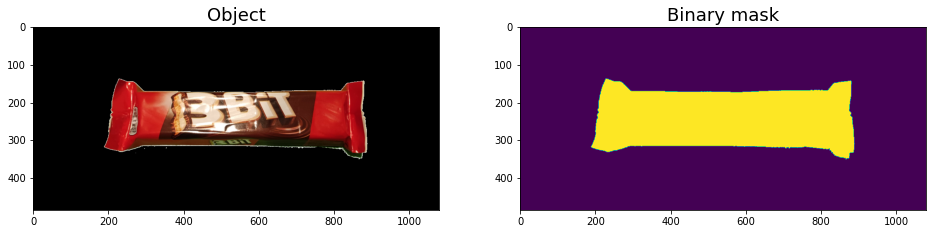

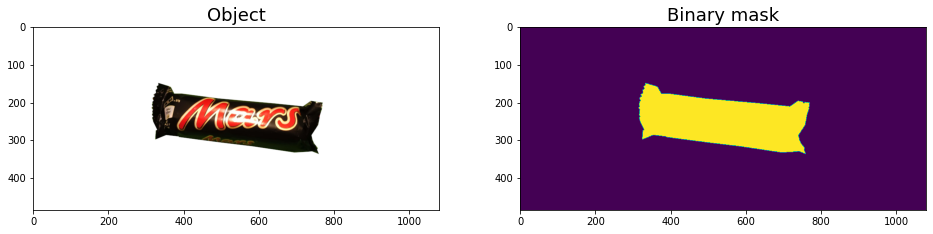

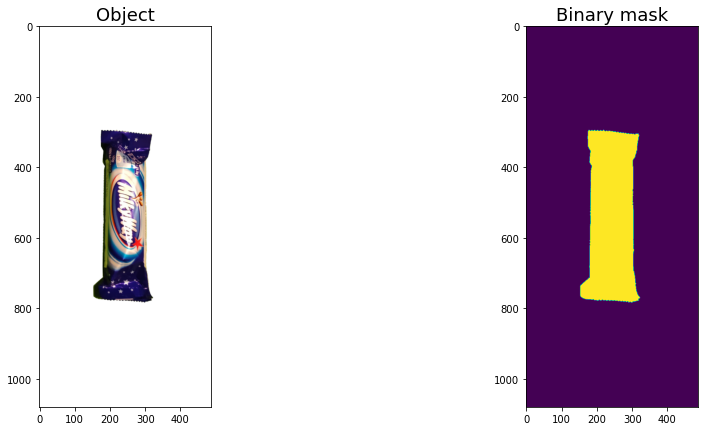

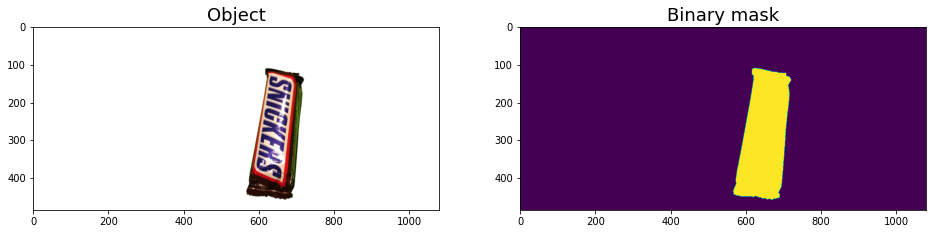

In [24]:
for i in range(1, len(obj_dict) + 1):
    img_path = obj_dict[i]['images'][0]
    mask_path = obj_dict[i]['masks'][0]

    img, mask = get_image_and_mask(img_path, mask_path)

    print("Image path:", img_path)
    print("Mask path:", mask_path)
    print("\nShape of the image of the object:", img.shape)
    print("Shape of the binary mask:", mask.shape)

    # Plot sample result
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ax[0].imshow(img)
    ax[0].set_title('Object', fontsize=18)
    ax[1].imshow(mask)
    ax[1].set_title('Binary mask', fontsize=18)

Resizing background images function

In [25]:
def resize_img(img, desired_max, desired_min=None):

  h, w = img.shape[0], img.shape[1]

  longest, shortest = max(h, w), min(h, w)
  longest_new = desired_max

  if desired_min:
    shortest_new = desired_min
  else:
    shortest_new = int(shortest * (longest_new / longest))

  if h > w:
    h_new, w_new = longest_new, shortest_new
  else:
    h_new, w_new = shortest_new, longest_new
  
  # transform size
  transform_resize = A.Compose([
    A.Sequential([
      A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)
    ], p=1)
  ])
  
  transformed = transform_resize(image = img)
  img_resized = transformed["image"]

  return img_resized


Test resizing function

Shape of the original background image: (2880, 1920, 3)
Shape of the resized background image (desired_max=1920, desired_min=None): (1920, 1280, 3)
Shape of the resized background image (desired_max=1920, desired_min=1080): (1920, 1080, 3)


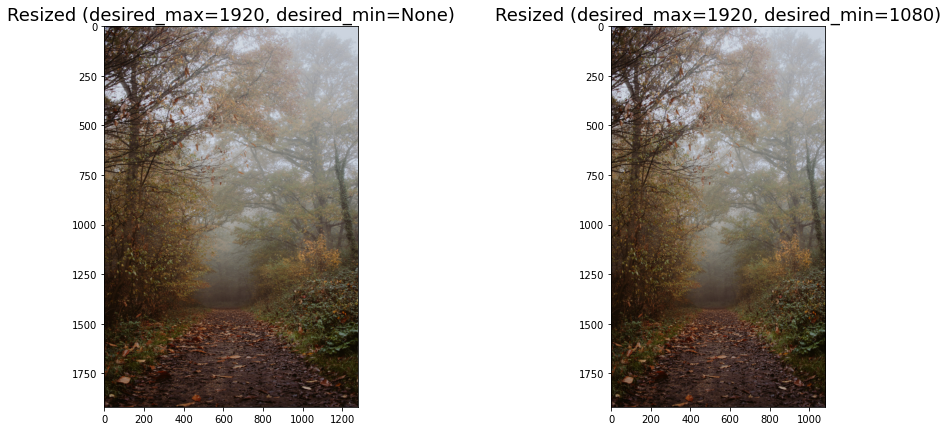

In [26]:
img_bg_path = files_bg_imgs[10]
img_bg = cv.imread(img_bg_path)
img_bg = cv.cvtColor(img_bg, cv.COLOR_BGR2RGB)

img_bg_resized_1 = resize_img(img_bg, desired_max=1920, desired_min=None)
img_bg_resized_2 = resize_img(img_bg, desired_max=1920, desired_min=1080)

print("Shape of the original background image:", img_bg.shape)

print("Shape of the resized background image (desired_max=1920, desired_min=None):", img_bg_resized_1.shape)
print("Shape of the resized background image (desired_max=1920, desired_min=1080):", img_bg_resized_2.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_bg_resized_1)
ax[0].set_title('Resized (desired_max=1920, desired_min=None)', fontsize=18)
ax[1].imshow(img_bg_resized_2)
ax[1].set_title('Resized (desired_max=1920, desired_min=1080)', fontsize=18);

Resizeing and transforming objects function, transforms from albumentations library can be based to the function as an optional argument 

In [27]:
def resize_transform_objects(img, mask, longest_min, longest_max, transforms=False):
  
  h, w = mask.shape[0], mask.shape[1]

  longest, shortest = max(h, w), min(h, w)
  longest_new = np.random.randint(longest_min, longest_max)
  shortest_new = int(shortest * (longest_new / longest))

  if h > w:
    h_new, w_new = longest_new, shortest_new
  else:
    h_new, w_new = shortest_new, longest_new
  
  transformed_resized = A.Resize(h_new, w_new, interpolation=1, 
                              always_apply=False, p=1)
  
  transformed_resized = transformed_resized(image=img, mask=mask)
  img_transformed = transformed_resized["image"]
  mask_transformed = transformed_resized["mask"]
  
  if transforms:
    transfromed = transforms(image=img_transformed, mask=mask_transformed)
    image_transformed = transfromed["image"]
    mask_transformed = transfromed["mask"]

  return image_transformed, mask_transformed

Define transfoms from albumentations library (more transfomration can be added later on)

In [28]:
transforms_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                               contrast_limit=0.1,
                               brightness_by_max=True,
                               always_apply=False,
                               p=1)
])

transforms_bg_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.ColorJitter(brightness=0.3, 
                  contrast=0.3,
                  saturation=0.3,
                  hue=0.07,
                  always_apply=False,
                  p=1)
])

Test transforming images function

Shape of the transformed object:  (336, 151, 3)
Shape of the transformed binary mask:  (336, 151)


Shape of the transformed object:  (318, 143, 3)
Shape of the transformed binary mask:  (318, 143)


Shape of the transformed object:  (335, 150, 3)
Shape of the transformed binary mask:  (335, 150)


Shape of the transformed object:  (386, 173, 3)
Shape of the transformed binary mask:  (386, 173)




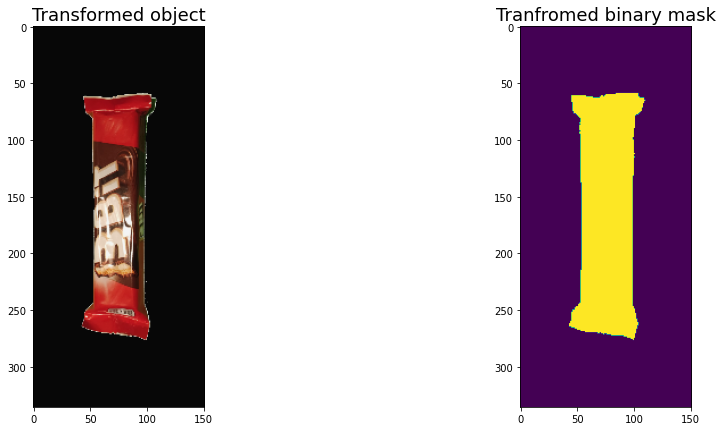

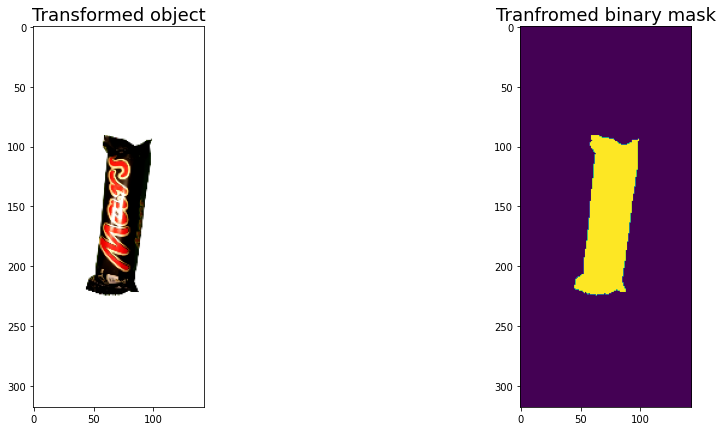

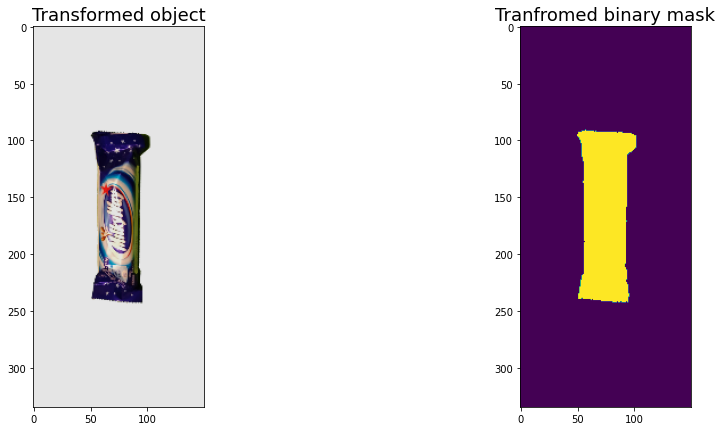

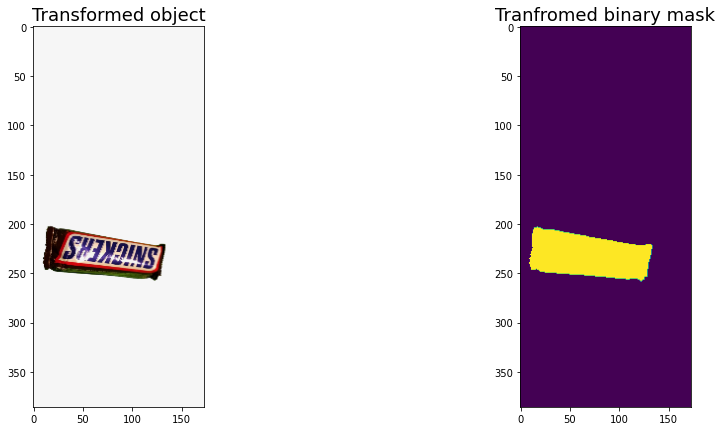

In [31]:
for i in range(1, len(obj_dict) + 1):
    img_path = obj_dict[i]["images"][0]
    mask_path = obj_dict[i]["masks"][0]

    img, mask = get_image_and_mask(img_path, mask_path)

    img_transfromed, mask_transfomred = resize_transform_objects(img, mask,
                                                        longest_min=300,
                                                        longest_max=400,
                                                        transforms=transforms_obj)

    print("Shape of the transformed object: ", img_transfromed.shape)
    print("Shape of the transformed binary mask: ", mask_transfomred.shape)
    print("\n")

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ax[0].imshow(img_transfromed)
    ax[0].set_title('Transformed object', fontsize=18)
    ax[1].imshow(mask_transfomred)
    ax[1].set_title('Tranfromed binary mask', fontsize=18);

Adding object to background

In [32]:
def add_obj(img_comp, mask_comp, img, mask, x, y, idx):
    '''
    img_comp - composition of objects
    mask_comp - composition of objects` masks
    img - image of object
    mask - binary mask of object
    x, y - coordinates where center of img is placed
    Function returns img_comp in CV2 RGB format + mask_comp
    '''
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]
    
    h, w = img.shape[0], img.shape[1]
    
    x = x - int(w/2)
    y = y - int(h/2)
    
    mask_b = mask == 1 
    mask_rgb_b = np.stack([mask_b, mask_b, mask_b], axis=2)
    
    if x >= 0 and y >= 0:
    
        h_part = h - max(0, y+h-h_comp) # h_part - part of the image which gets into the frame of img_comp along y-axis
        w_part = w - max(0, x+w-w_comp) # w_part - part of the image which gets into the frame of img_comp along x-axis

        img_comp[y:y+h_part, x:x+w_part, :] = img_comp[y:y+h_part, x:x+w_part, :] * ~mask_rgb_b[0:h_part, 0:w_part, :] + (img * mask_rgb_b)[0:h_part, 0:w_part, :]
        mask_comp[y:y+h_part, x:x+w_part] = mask_comp[y:y+h_part, x:x+w_part] * ~mask_b[0:h_part, 0:w_part] + (idx * mask_b)[0:h_part, 0:w_part]
        mask_added = mask[0:h_part, 0:w_part]
        
    elif x < 0 and y < 0:
        
        h_part = h + y
        w_part = w + x
        
        img_comp[0:0+h_part, 0:0+w_part, :] = img_comp[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_b[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_b)[h-h_part:h, w-w_part:w, :]
        mask_comp[0:0+h_part, 0:0+w_part] = mask_comp[0:0+h_part, 0:0+w_part] * ~mask_b[h-h_part:h, w-w_part:w] + (idx * mask_b)[h-h_part:h, w-w_part:w]
        mask_added = mask[h-h_part:h, w-w_part:w]
        
    elif x < 0 and y >= 0:
        
        h_part = h - max(0, y+h-h_comp)
        w_part = w + x
        
        img_comp[y:y+h_part, 0:0+w_part, :] = img_comp[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_b[0:h_part, w-w_part:w, :] + (img * mask_rgb_b)[0:h_part, w-w_part:w, :]
        mask_comp[y:y+h_part, 0:0+w_part] = mask_comp[y:y+h_part, 0:0+w_part] * ~mask_b[0:h_part, w-w_part:w] + (idx * mask_b)[0:h_part, w-w_part:w]
        mask_added = mask[0:h_part, w-w_part:w]
        
    elif x >= 0 and y < 0:
        
        h_part = h + y
        w_part = w - max(0, x+w-w_comp)
        
        img_comp[0:0+h_part, x:x+w_part, :] = img_comp[0:0+h_part, x:x+w_part, :] * ~mask_rgb_b[h-h_part:h, 0:w_part, :] + (img * mask_rgb_b)[h-h_part:h, 0:w_part, :]
        mask_comp[0:0+h_part, x:x+w_part] = mask_comp[0:0+h_part, x:x+w_part] * ~mask_b[h-h_part:h, 0:w_part] + (idx * mask_b)[h-h_part:h, 0:w_part]
        mask_added = mask[h-h_part:h, 0:w_part]
    
    return img_comp, mask_comp, mask_added

Add object to background

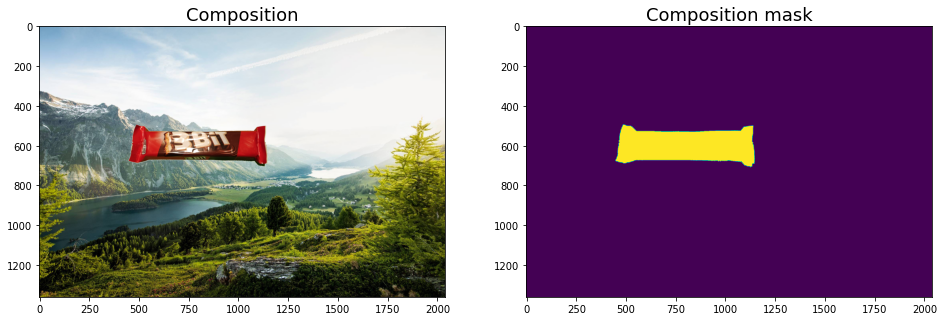

In [33]:
img_bg_path = files_bg_imgs[26]
img_bg = cv.imread(img_bg_path)
img_bg = cv.cvtColor(img_bg, cv.COLOR_BGR2RGB)

h, w = img_bg.shape[0], img_bg.shape[1]
mask_comp = np.zeros((h,w), dtype=np.uint8)

img_path = obj_dict[1]['images'][0]
mask_path = obj_dict[1]['masks'][0]
img, mask = get_image_and_mask(img_path, mask_path)

img_comp, mask_comp, _ = add_obj(img_bg, mask_comp, img, mask, x=800, y=600, idx=1)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18);

Try to add one more item

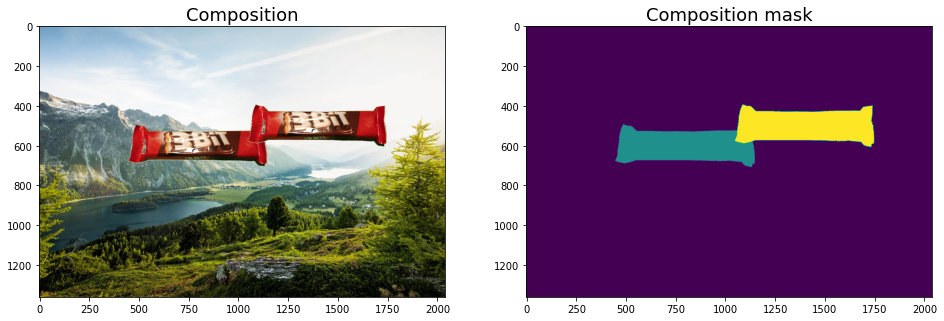

In [34]:
img_comp, mask_comp, _ = add_obj(img_comp, mask_comp, img, mask, 1400, 500, idx=2)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18);

Adding noise objects to background

In [36]:
def create_bg_with_noise(files_bg_imgs, 
                    files_bg_noise_imgs,
                    files_bg_noise_masks,
                    bg_max=1920,
                    bg_min=1080,
                    max_objs_to_add=60,
                    longest_bg_noise_max=1000,
                    longest_bg_noise_min=200,
                    blank_bg=False):

    if blank_bg:
        img_comp_bg = np.zeros((bg_min, bg_max, 3), dtype=np.uint8) + 255
        mask_comp_bg = np.zeros((bg_min, bg_max), dtype=np.uint8)
                                
    else:
        idx = np.random.randint(len(files_bg_imgs))
        img_bg = cv.imread(files_bg_imgs[idx])
        img_bg = cv.cvtColor(img_bg, cv.COLOR_BGR2RGB)
        img_comp_bg = resize_img(img_bg, bg_max, bg_min)
        mask_comp_bg = np.zeros((img_comp_bg.shape[0], img_comp_bg.shape[1]), dtype=np.uint8)

    for i in range(1, np.random.randint(max_objs_to_add) + 2): # make sure its at least range(1, 2)

        idx = np.random.randint(len(files_bg_noise_imgs))

        # print(files_bg_noise_imgs)
        # print(files_bg_noise_masks)

        img, mask = get_image_and_mask(files_bg_noise_imgs[idx], files_bg_noise_masks[idx])
        x, y = np.random.randint(img_comp_bg.shape[1]), np.random.randint(img_comp_bg.shape[0])
        img_t, mask_t = resize_transform_objects(img, mask, longest_bg_noise_min, 
                                             longest_bg_noise_max, transforms=transforms_bg_obj)
        img_comp_bg, _, _ = add_obj(img_comp_bg, mask_comp_bg, img_t, mask_t, x, y, i)

    return img_comp_bg

Test adding noise function

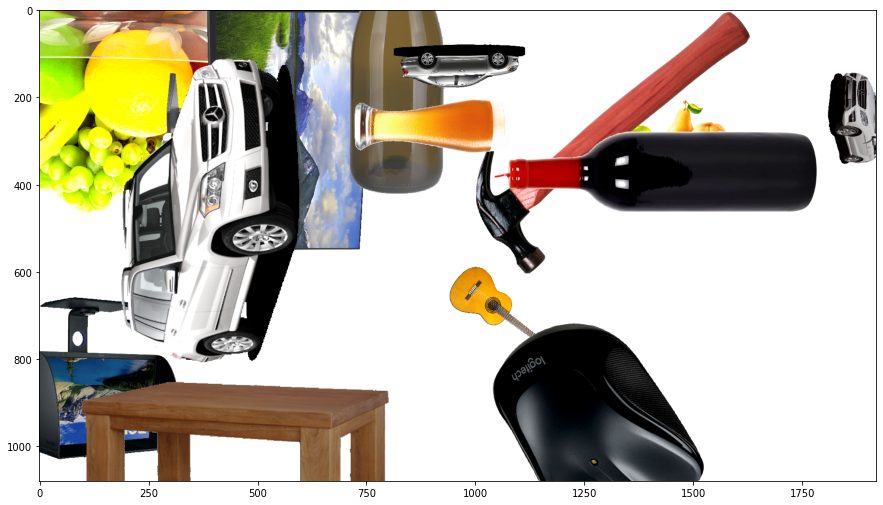

In [37]:
img_comp_bg = create_bg_with_noise(files_bg_imgs, files_bg_noise_imgs, 
                                   files_bg_noise_masks,
                                   max_objs_to_add=20,
                                   blank_bg=True)

plt.figure(figsize=(15, 15))
plt.imshow(img_comp_bg)

Test adding noise with background

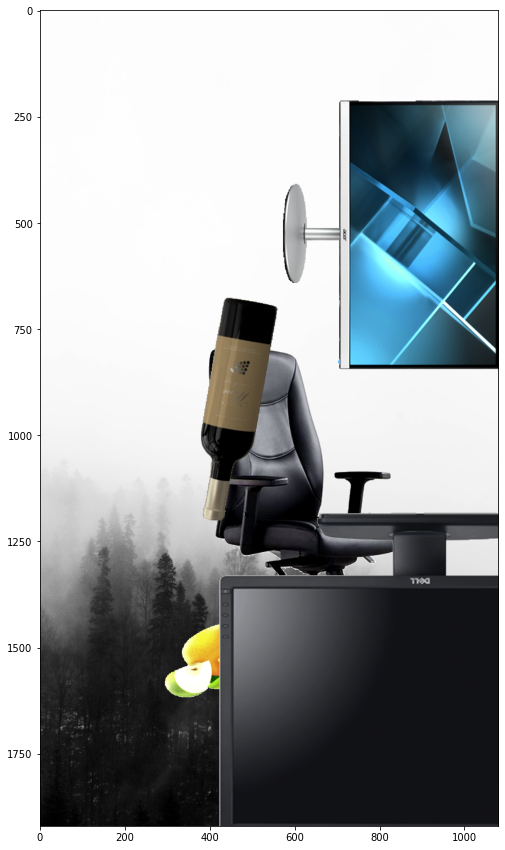

In [38]:
img_comp_bg = create_bg_with_noise(files_bg_imgs, files_bg_noise_imgs, 
                                   files_bg_noise_masks,
                                   max_objs_to_add=20)
plt.figure(figsize=(15,15))
plt.imshow(img_comp_bg)

Controlling overlapping

In [39]:
def check_areas(mask_comp, obj_areas, overlap_degree=0.3):
    
    obj_ids=np.unique(mask_comp).astype(np.uint8)[1:-1]
    masks = mask_comp == obj_ids[:, None, None]
    ret = True

    if len(np.unique(mask_comp)) != np.max(mask_comp) + 1:
        ret = False
        return ret

    for idx, mask in enumerate(masks):
        if np.count_nonzero(mask) / obj_areas[idx] < 1 - overlap_degree:
            ret = False
            break

    return ret

Create synthetic composition

In [40]:
def create_composition(img_comp_bg,
                       max_objs=15,
                       overlap_degree=0.2,
                       max_attempts_per_obj=10):

    img_comp = img_comp_bg.copy()
    h, w = img_comp.shape[0], img_comp.shape[1]
    mask_comp = np.zeros((h,w), dtype=np.uint8)
    
    obj_areas = []
    labels_comp = []
    num_objs = np.random.randint(max_objs) + 2
    
    i = 1
    
    for _ in range(1, num_objs):

        obj_idx = np.random.randint(len(obj_dict)) + 1
        
        for _ in range(max_attempts_per_obj):

            imgs_number = len(obj_dict[obj_idx]['images'])
            idx = np.random.randint(imgs_number)
            img_path = obj_dict[obj_idx]['images'][idx]
            mask_path = obj_dict[obj_idx]['masks'][idx]
            img, mask = get_image_and_mask(img_path, mask_path)

            x, y = np.random.randint(w), np.random.randint(h)
            longest_min = obj_dict[obj_idx]['longest_min']
            longest_max = obj_dict[obj_idx]['longest_max']
            img, mask = resize_transform_objects(img,
                                             mask,
                                             longest_min,
                                             longest_max,
                                             transforms=transforms_obj)

            if i == 1:
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                obj_areas.append(np.count_nonzero(mask_added))
                labels_comp.append(obj_idx)
                i += 1
                break
            else:        
                img_comp_prev, mask_comp_prev = img_comp.copy(), mask_comp.copy()
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                ok = check_areas(mask_comp, obj_areas, overlap_degree)
                if ok:
                    obj_areas.append(np.count_nonzero(mask_added))
                    labels_comp.append(obj_idx)
                    i += 1
                    break
                else:
                    img_comp, mask_comp = img_comp_prev.copy(), mask_comp_prev.copy()        
        
    return img_comp, mask_comp, labels_comp, obj_areas

Test synthetic composition

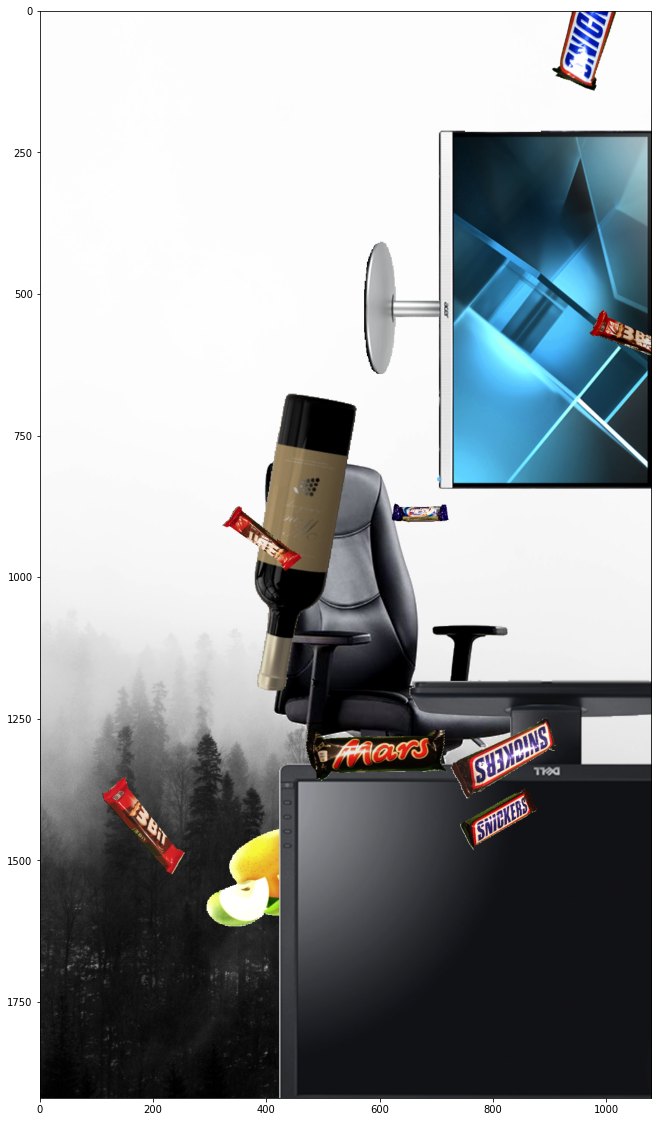

In [41]:
img_comp, mask_comp, labels_comp, obj_areas = create_composition(img_comp_bg,
                                                                 max_objs=15,
                                                                 overlap_degree=0.2,
                                                                 max_attempts_per_obj=10)

plt.figure(figsize=(20, 20))
plt.imshow(img_comp)

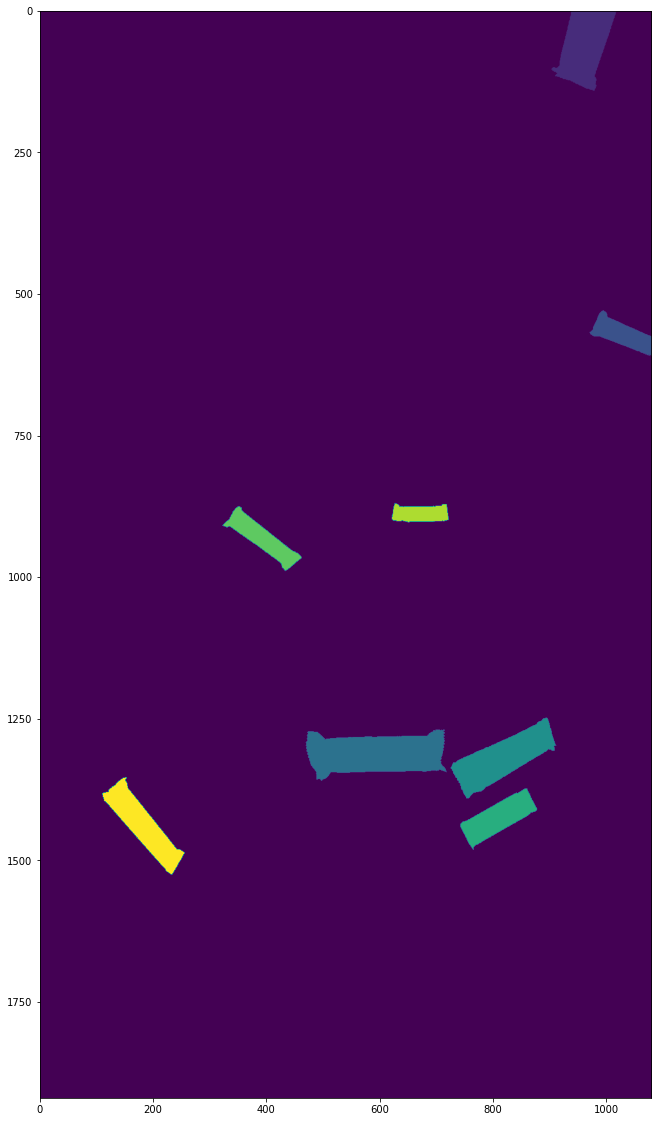

In [42]:
plt.figure(figsize=(20, 20))
plt.imshow(mask_comp)

In [43]:
print("Labels: ", labels_comp)

Labels:  [4, 1, 2, 4, 4, 1, 3, 1]


Look how much each object is being overlaped (1 means no overlap)

In [44]:
obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
masks = mask_comp == obj_ids[:, None, None]

print("How much each area of each object is overlaped")

for idx, mask in enumerate(masks):
    print(np.count_nonzero(mask) / obj_areas[idx])

How much each area of each object is overlaped
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


Draw bounding boxes for each added object

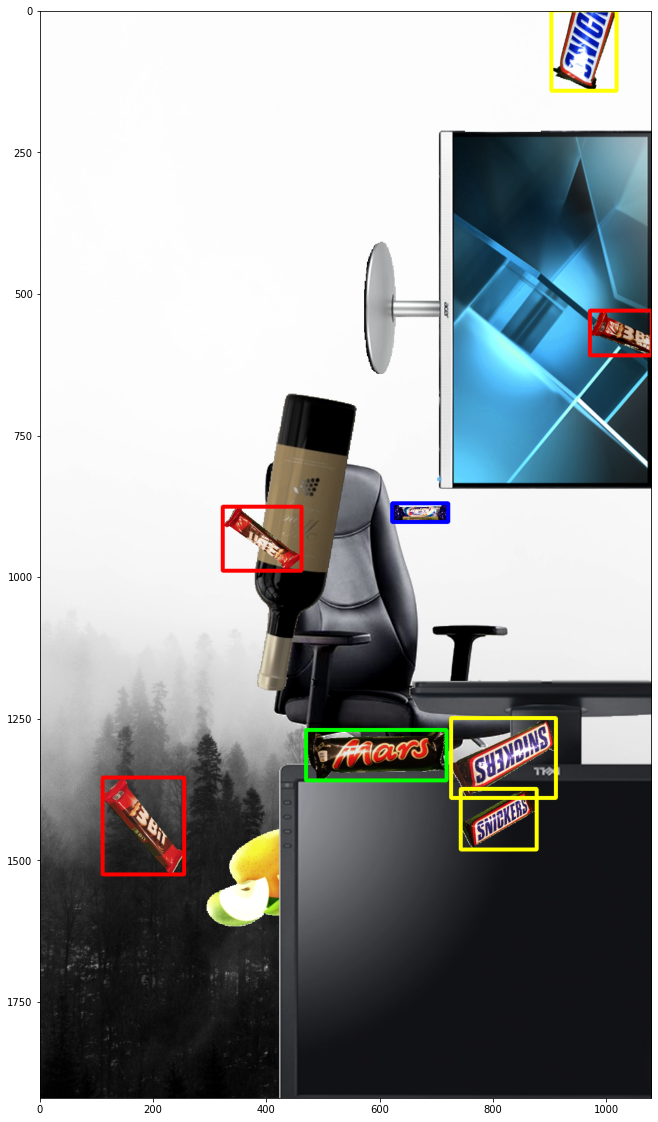

In [47]:
colors = {1: (255, 0, 0), 2: (0, 255, 0), 3: (0, 0, 255), 4: (255, 255, 0)}

img_comp_bboxes = img_comp.copy()

obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
mask = mask_comp == obj_ids[:, None, None]

for i in range(len(obj_ids)):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    img_comp_boxes = cv.rectangle(img_comp_bboxes,
                                (xmin, ymin),
                                (xmax, ymax),
                                colors[labels_comp[i]],
                                6)

plt.figure(figsize=(20, 20))
plt.imshow(img_comp_bboxes)

Create annotations in YOLO fromat

In [48]:
def create_yolo_annotations(mask_comp, labels_comp):
    comp_w, comp_h = mask_comp.shape[1], mask_comp.shape[0]

    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
    masks = mask_comp == obj_ids[:, None, None]

    annotations_yolo = []

    for i in range(len(labels_comp)):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        xc = (xmin + xmax) / 2
        yc = (ymin + ymax) / 2
        h = ymax - ymin
        w = xmax - xmin

        annotations_yolo.append([labels_comp[i] - 1,
                                 round(xc/comp_w, 5),
                                 round(yc/comp_h, 5),
                                 round(w/comp_w, 5),
                                 round(h/comp_h, 5)])

    return annotations_yolo

Test sample yolo output

In [49]:
annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
for i in range(len(annotations_yolo)):
    print(' '.join(str(el) for el in annotations_yolo[i]))

3 0.88843 0.03698 0.10648 0.07396
0 0.94861 0.29661 0.10093 0.04115
1 0.54907 0.68464 0.22963 0.04635
3 0.75694 0.68724 0.1713 0.07344
3 0.74907 0.74349 0.12407 0.05573
0 0.3625 0.48568 0.1287 0.05885
2 0.62083 0.46172 0.09167 0.01719
0 0.16852 0.74974 0.13333 0.08906


Generate a dataset

In [50]:
def generate_dataset(imgs_number, folder, split='train'):
    time_start = time.time()
    for j in tqdm(range(imgs_number)):
        img_comp_bg = create_bg_with_noise(files_bg_imgs,
                                           files_bg_noise_imgs,
                                           files_bg_noise_masks,
                                           max_objs_to_add=60)
        
        img_comp, mask_comp, labels_comp, _ = create_composition(img_comp_bg,
                                                                 max_objs=15,
                                                                 overlap_degree=0.2,
                                                                 max_attempts_per_obj=10)

        img_comp = cv.cvtColor(img_comp, cv.COLOR_RGB2BGR)
        cv.imwrite(os.path.join(folder, split, 'images/{}.jpg').format(j), img_comp)

        annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
        for i in range(len(annotations_yolo)):
            with open(os.path.join(folder, split, 'labels/{}.txt').format(j), "a") as f:
                f.write(' '.join(str(el) for el in annotations_yolo[i]) + '\n')
                
    time_end = time.time()
    time_total = round(time_end - time_start)
    time_per_img = round((time_end - time_start) / imgs_number, 1)
    
    print("Generation of {} synthetic images is completed. It took {} seconds, or {} seconds per image".format(imgs_number, time_total, time_per_img))
    print("Images are stored in '{}'".format(os.path.join(folder, split, 'images')))
    print("Annotations are stored in '{}'".format(os.path.join(folder, split, 'labels')))

Remember to manualy create dataset/train and dataset/val output folders with labels and images subfolders


In [51]:
!mkdir -p dataset/{train/{labels,images},val/{labels,images}}

In [52]:
generate_dataset(1000, folder='dataset', split='train')
generate_dataset(200, folder='dataset', split='val')

100%|██████████| 1000/1000 [45:18<00:00,  2.72s/it]


Generation of 1000 synthetic images is completed. It took 2718 seconds, or 2.7 seconds per image
Images are stored in 'dataset/train/images'
Annotations are stored in 'dataset/train/labels'


100%|██████████| 200/200 [08:28<00:00,  2.54s/it]

Generation of 200 synthetic images is completed. It took 509 seconds, or 2.5 seconds per image
Images are stored in 'dataset/val/images'
Annotations are stored in 'dataset/val/labels'


In [53]:
!zip -r dataset.zip dataset

  adding: dataset/ (stored 0%)
  adding: dataset/train/ (stored 0%)
  adding: dataset/train/images/ (stored 0%)
  adding: dataset/train/images/878.jpg (deflated 0%)
  adding: dataset/train/images/436.jpg (deflated 1%)
  adding: dataset/train/images/23.jpg (deflated 0%)
  adding: dataset/train/images/20.jpg (deflated 0%)
  adding: dataset/train/images/871.jpg (deflated 0%)
  adding: dataset/train/images/134.jpg (deflated 0%)
  adding: dataset/train/images/437.jpg (deflated 0%)
  adding: dataset/train/images/627.jpg (deflated 0%)
  adding: dataset/train/images/589.jpg (deflated 0%)
  adding: dataset/train/images/113.jpg (deflated 0%)
  adding: dataset/train/images/780.jpg (deflated 0%)
  adding: dataset/train/images/386.jpg (deflated 1%)
  adding: dataset/train/images/202.jpg (deflated 0%)
  adding: dataset/train/images/902.jpg (deflated 0%)
  adding: dataset/train/images/198.jpg (deflated 0%)
  adding: dataset/train/images/96.jpg (deflated 0%)
  adding: dataset/train/images/815.jpg (def